In [1]:
import sys
from pathlib import Path
ROOT_DIR = Path().resolve().parents[0]
sys.path.append(str(ROOT_DIR))
import config as cfg

import os
import json
import numpy as np
from sklearn.metrics import roc_auc_score
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import load_from_disk
import pandas as pd
import math
import matplotlib.pyplot as plt

N_RUN = 0

# Training analysis across folds

In [2]:
def get_checkpoint_steps_from_fold(n_run, fold_id):
    path_fold_dir = os.path.join(cfg.PATH_CHECKPOINTS, cfg.MODEL_BASE, f"run_{n_run}", f"fold_{fold_id}")
    checkpoints = [int(folder.split("checkpoint-")[-1]) for folder in os.listdir(path_fold_dir) if folder.startswith("checkpoint")]
    return sorted(checkpoints)

In [3]:
def get_best_metric_from_fold(n_run, fold_id):
    last_checkpoint = max(get_checkpoint_steps_from_fold(n_run, fold_id))
    path_trainer_state = os.path.join(
        cfg.PATH_CHECKPOINTS, cfg.MODEL_BASE, f"run_{n_run}", f"fold_{fold_id}",
        f"checkpoint-{last_checkpoint}", "trainer_state.json"
    )
    
    try:
        with open(path_trainer_state, "r") as f:
            trainer_state = json.load(f)
        return trainer_state["best_metric"]
    except FileNotFoundError:
        print(f"File not found: {path_trainer_state}")
        return None

In [4]:
# Get the best roc_auc_macro from each fold
fold_scores = {f"fold_{fold_id}_roc_auc_macro": get_best_metric_from_fold(N_RUN, fold_id) for fold_id in range(cfg.N_FOLDS)}
fold_scores

{'fold_0_roc_auc_macro': 0.988704817025802,
 'fold_1_roc_auc_macro': 0.9882707078896035,
 'fold_2_roc_auc_macro': 0.991930075119802,
 'fold_3_roc_auc_macro': 0.9900226678585309,
 'fold_4_roc_auc_macro': 0.9913572009696786}

In [5]:
# Calculate the mean roc_auc_macro across all folds
print(f"Mean roc_auc_macro across all folds: {np.mean(list(fold_scores.values()))}")

Mean roc_auc_macro across all folds: 0.9900570937726835


In [6]:
# Calculate the std dev of the roc_auc_macro across all folds
print(f"Std dev roc_auc_macro across all folds: {np.std(list(fold_scores.values()))}")

Std dev roc_auc_macro across all folds: 0.0014296398089953676


## Conclusions

The ROC AUC macro scores across the five folds are very high, with a mean of approximately 0.990057.

Moreover, the small standard deviation (~0.001430) indicates minimal variation between the folds. This suggests not only that the model performs well when generalizing, but also that these strong results are not dependent on any particular data split.

We can conclude that the model generalizes exceptionally well.

# Learning and ROC-AUC curves

## Calculate data for plots

In [7]:
def get_fold_datasets(ds, fold):
    ds_train = ds.filter(lambda x: x["fold"] != fold)
    ds_val = ds.filter(lambda x: x["fold"] == fold)
    return ds_train, ds_val

In [8]:
def eval_checkpoint(n_run, fold_id, step, ds_train, ds_val):
    
    def _compute_metrics(eval_pred):
        logits, labels = eval_pred
        probs = 1 / (1 + np.exp(-logits))
        auc = roc_auc_score(labels, probs, average="macro")
        return {"roc_auc_macro": auc}

    # Load the model trained at given checkpoint
    # path_checkpoint = f"checkpoints/{cfg.MODEL_BASE}/run_{N_RUN}/fold_{fold_id}/checkpoint-{step}"
    path_checkpoint_dir = os.path.join(cfg.PATH_CHECKPOINTS, f"run_{n_run}", f"fold_{fold_id}", f"checkpoint-{step}")
    model_trained = AutoModelForSequenceClassification.from_pretrained(path_checkpoint_dir).to("cuda")

    # Instantiate TrainingArguments and Trainer for evaluation
    eval_args = TrainingArguments(
        # output_dir="./tmp_eval",
        per_device_eval_batch_size=cfg.BATCH_SIZE,
        dataloader_num_workers=2,
        fp16=True,
        save_strategy="no",
        evaluation_strategy="no",
    )
    eval_trainer = Trainer(
        model=model_trained,
        args=eval_args,
        compute_metrics=_compute_metrics
    )

    # Evaluate the model on the train and validation datasets
    metrics_train = eval_trainer.evaluate(eval_dataset=ds_train)
    metrics_val = eval_trainer.evaluate(eval_dataset=ds_val)

    return {
        "fold_id": fold_id,
        "n_run": n_run,
        "step": step,
        "train_loss": metrics_train["eval_loss"],
        "val_loss": metrics_val["eval_loss"],
        "train_roc_auc_macro": metrics_train["eval_roc_auc_macro"],
        "val_roc_auc_macro": metrics_val["eval_roc_auc_macro"],
    }

In [9]:
# Calculate the points for the plot from the checkpoints if they haven't been
# calculated before, or load them otherwise.

if not os.path.exists(cfg.PATH_DF_SCORES):
    
    # Initialize var
    scores = []

    # Load the tokenized dataset
    ds_train_tokenized = load_from_disk(cfg.PATH_DS_TRAIN_TOKENIZED)
    
    # Loop the folds to evaluate all the checkpoints steps
    for fold_id in range(cfg.N_FOLDS):
        print(f"Evaluating fold {fold_id}...")
        # Get the train/validation splits
        ds_train, ds_val = get_fold_datasets(ds_train_tokenized, fold_id)
        # Get all the checkpoints steps in the run
        steps = get_checkpoint_steps_from_fold(N_RUN, fold_id)
        for step in steps:
            print(f"\tEvaluating step {step}...")
            scores.append(eval_checkpoint(fold_id, N_RUN, step, ds_train, ds_val))

    # Calculate the number of steps per epoch, to then calculate the epoch
    steps_per_epoch = math.ceil(len(ds_train) / cfg.BATCH_SIZE)

    # Create a df with the results
    df_scores = pd.DataFrame(scores)
    df_scores["epoch"] = df_scores["step"] / steps_per_epoch
    df_scores.insert(2, "epoch", df_scores.pop("epoch"))
    df_scores.to_csv(cfg.PATH_DF_SCORES, index=False)

else:
    df_scores = pd.read_csv(cfg.PATH_DF_SCORES)

## Plot results

In [10]:
fold_id = 0
df_filtered = df_scores[df_scores["fold_id"] == fold_id]

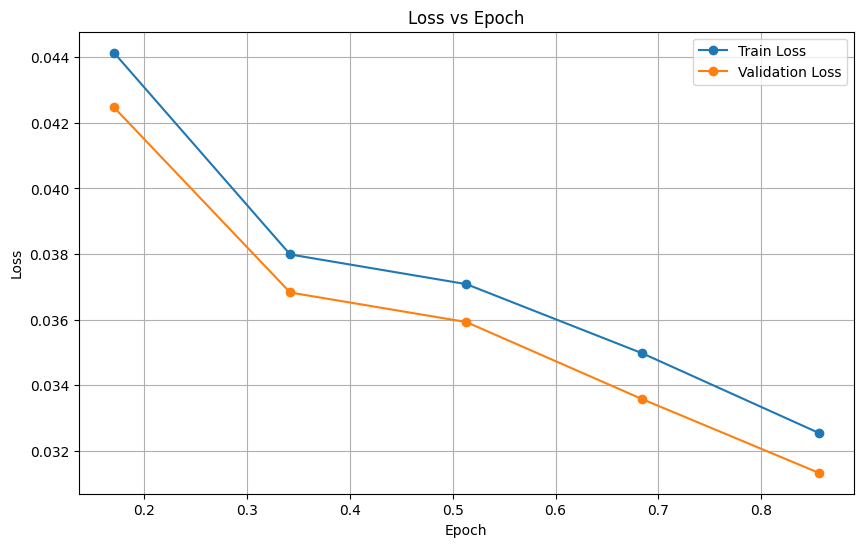

In [11]:
# Loss vs Epoch Plot
plt.figure(figsize=(10, 6))
plt.plot(df_filtered["epoch"], df_filtered["train_loss"], marker="o", label='Train Loss')
plt.plot(df_filtered["epoch"], df_filtered["val_loss"], marker="o", label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

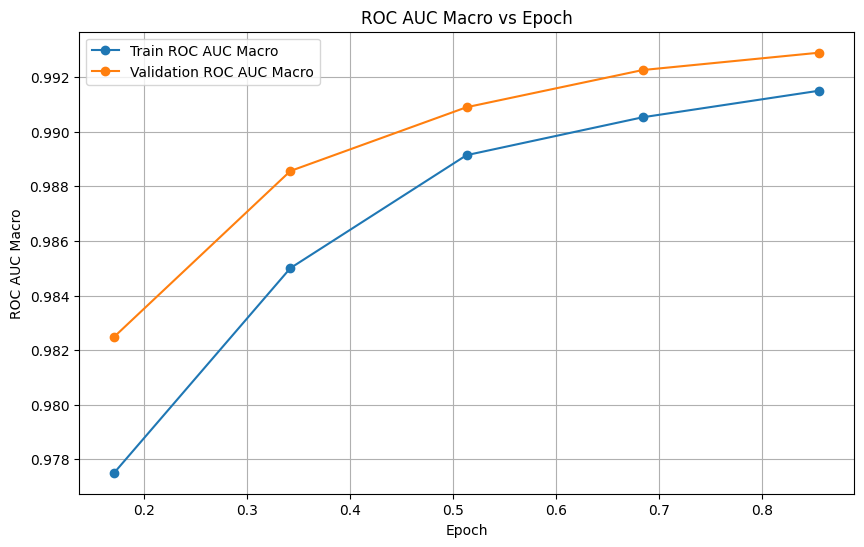

In [12]:
# ROC AUC vs Epoch Plot
plt.figure(figsize=(10, 6))
plt.plot(df_filtered["epoch"], df_filtered["train_roc_auc_macro"], marker="o", label='Train ROC AUC Macro')
plt.plot(df_filtered["epoch"], df_filtered["val_roc_auc_macro"], marker="o", label='Validation ROC AUC Macro')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC Macro")
plt.title("ROC AUC Macro vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Conclusions

TBD